# Sensitive Set Transport Invariant Ranking (SenSTIR) demo

The idea of this notebook is to replicate the synthetic experiment shown in figure 1 of [Individually Fair Rankings](https://openreview.net/pdf?id=71zCSP_HuBN).

## Synthetic data generation

In [1]:
import numpy as np
import torch
from torch import nn
from torch.utils.data.sampler import RandomSampler, BatchSampler
from torch.utils.data import IterableDataset

In [2]:
def generate_synthetic_LTR_data(majority_proportion = .8, num_queries = 100, num_docs_per_query = 10, seed=0):
    num_items = num_queries*num_docs_per_query
    X = np.random.uniform(0,3, size = (num_items,2)).astype(np.float32)
    relevance = X[:,0] + X[:,1]
    
    relevance = np.clip(relevance, 0.0,5.0)
    majority_status = np.random.choice([True, False], size=num_items, p=[majority_proportion, 1-majority_proportion])
    X[~majority_status, 1] = 0
    return [{"Q":X[i], "relevances":relevance[i], "majority_status":majority_status[i]} for i in range(num_items)]

In [3]:
class QueryIterableDataset(IterableDataset):
    '''
    iterable dataset that takes a set of items and indifintely samples sets of such items (queries) per iteration
    '''
    def __init__(self, items_dataset, shuffle, query_size):
        self.dataset = items_dataset
        self.query_size = query_size
        self.shuffle = shuffle

    def __iter__(self):
        while True:
            idx = self._infinite_indices()
            query = [self.dataset[i] for i in next(idx)]
            query = torch.utils.data.default_collate(query)
            yield query
    
    def _infinite_indices(self):
        worker_info = torch.utils.data.get_worker_info()
        seed = 0 if worker_info is None else worker_info.id
        g = torch.Generator()
        g.manual_seed(seed)
        while True:
            if self.shuffle:
                idx = (torch.randperm(len(self.dataset))[:self.query_size]).tolist()
                yield idx

In [4]:
num_docs_per_query = 10
num_queries = 100
dataset_train = generate_synthetic_LTR_data(num_queries = num_queries, num_docs_per_query = num_docs_per_query)
dataloader = torch.utils.data.DataLoader(QueryIterableDataset(dataset_train, True, num_docs_per_query), num_workers=2, batch_size=2)
#the data loader gets a batch of queries with relevance (batch x num_items_per_query) and features (batch x num_items_per_query x num_features)
next(iter(dataloader))

{'Q': tensor([[[2.6474, 1.5874],
          [0.0723, 1.9139],
          [1.8355, 0.0000],
          [2.9429, 0.6647],
          [0.8362, 0.8691],
          [2.3764, 1.9852],
          [1.2717, 2.7427],
          [2.7849, 1.0166],
          [2.7567, 1.3963],
          [2.2352, 0.0000]],
 
         [[0.4390, 2.3352],
          [0.4656, 1.0055],
          [1.1422, 1.8538],
          [1.5224, 1.9929],
          [2.5632, 2.2393],
          [2.0489, 1.9064],
          [1.6355, 2.9871],
          [1.0142, 1.0790],
          [0.2547, 0.0000],
          [1.0790, 0.0000]]]),
 'relevances': tensor([[4.2348, 1.9862, 3.7030, 3.6076, 1.7054, 4.3616, 4.0144, 3.8015, 4.1530,
          3.2489],
         [2.7742, 1.4712, 2.9959, 3.5153, 4.8025, 3.9553, 4.6227, 2.0932, 2.9363,
          1.7769]]),
 'majority_status': tensor([[ True,  True, False,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False]])}

## fair distance learning

This is necessary to compute the wasserstein distance on the worst example generation (q' in the paper)

In [5]:
# we perform a logistic regression on the dataset to build a sensitive direction
from sklearn.linear_model import LogisticRegression

all_data = torch.utils.data.default_collate(dataset_train)
x = all_data['Q']
majority_status = all_data['majority_status']

LR = LogisticRegression(C = 100).fit(x, majority_status)

sens_directions = torch.tensor(LR.coef_,dtype=torch.float32).T
print('sensitive directions', sens_directions)


sensitive directions tensor([[ 0.1369],
        [48.4704]])


As we can see, the logistic regression finds a high sensitivity on the second dimension, the data generation process artificially produces this high correlation.

### Batched Wasserstein Distance

To audit the model we need to compute a Wasserstein distance between sets of items. This distance can be build by using a Mahalonobis distance as the pairwise cost between items in each set. The sensitive direction we just learned can be used to build this Mahalanobis distance.

In [6]:
from inFairness.distances import SensitiveSubspaceDistance, BatchedWassersteinDistance

In [7]:
distance_q = BatchedWassersteinDistance(SensitiveSubspaceDistance())
distance_q.fit(sens_directions)

## Model and Output distance

We also need a model we would like to train and to define a distance in the output space.

In [8]:
import torch.nn.functional as F
class MultilayerPerceptron(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model1 = MultilayerPerceptron()

In [9]:
from inFairness.distances import SquaredEuclideanDistance
distance_y = SquaredEuclideanDistance()
distance_y.fit(num_dims=num_docs_per_query)

It's worth nothing that in the output space we are measuring distances between sets of scores (each score corresponding to each document in a query). Therefore the dimensionality of the SquaredEuclideanDistance above.

## SenSTIR

High rho to enforce fairness.

In [10]:
from inFairness.fairalgo import SenSTIR
fairalgo1 = SenSTIR(
    network=model1,
    distance_q=distance_q,
    distance_y=distance_y,
    rho=0.05,
    eps=1.0,
    auditor_nsteps=100,
    auditor_lr=0.1,
    monte_carlo_samples_ndcg=20,
)
fairalgo1.train()

SenSTIR(
  (network): MultilayerPerceptron(
    (fc1): Linear(in_features=2, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=10, bias=True)
    (fc3): Linear(in_features=10, out_features=1, bias=True)
  )
  (distance_q): BatchedWassersteinDistance(
    (distance): SensitiveSubspaceDistance()
  )
  (distance_y): SquaredEuclideanDistance()
)

## Baseline

Set rho to 0 to train the network normally.

In [11]:
from inFairness.fairalgo import SenSTIR
baseline = SenSTIR(
    network=MultilayerPerceptron(),
    distance_q=distance_q,
    distance_y=distance_y,
    rho=0.0,
    eps=1.0,
    auditor_nsteps=100,
    auditor_lr=0.03,
    monte_carlo_samples_ndcg=20,
)
baseline.train()

SenSTIR(
  (network): MultilayerPerceptron(
    (fc1): Linear(in_features=2, out_features=10, bias=True)
    (fc2): Linear(in_features=10, out_features=10, bias=True)
    (fc3): Linear(in_features=10, out_features=1, bias=True)
  )
  (distance_q): BatchedWassersteinDistance(
    (distance): SensitiveSubspaceDistance()
  )
  (distance_y): SquaredEuclideanDistance()
)

# Training Loop

In [12]:
%%time
from trainer import Trainer
trainer = Trainer(
    dataloader=dataloader,
    model=baseline,
    optimizer=torch.optim.Adam(baseline.parameters(),lr=0.005),
    max_iterations = 1000
)
trainer.train()

CPU times: user 3.24 s, sys: 246 ms, total: 3.48 s
Wall time: 3.89 s


In [17]:
%%time
trainer = Trainer(
    dataloader=dataloader,
    model=fairalgo1,
    optimizer=torch.optim.Adam(fairalgo1.parameters(),lr=0.001),
    max_iterations = 500
)

trainer.train()

CPU times: user 5h 31min 27s, sys: 8min 10s, total: 5h 39min 37s
Wall time: 7min 4s


# Visualize Results

<Figure size 432x720 with 0 Axes>

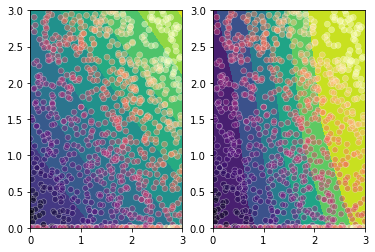

In [18]:
from matplotlib import pyplot as plt
from matplotlib.cm import ScalarMappable

import seaborn as sns
import numpy as np

fairmodel = fairalgo1.network.eval()
baselinemodel = baseline.network.eval()

range_x = np.linspace(0,3,num=100).astype(np.float32)
range_y = np.linspace(0,3, num= 100).astype(np.float32)

def get_predicted_scores(model):
    xx, yy = np.meshgrid(range_x, range_y, sparse=False)
    y_pred = []

    for i in range(100):
        x = xx[i].reshape(-1, 1)
        y = yy[i].reshape(-1, 1)
        x_test = np.hstack([x, y])
        y_pred.append(model(torch.Tensor(x_test)).detach().numpy()[:, 0])
    
    return y_pred
        
def plot_contours_and_relevances(scores_pred, ax):
    scores_pred = np.array(scores_pred)
    ax.contourf(range_x, range_y, scores_pred)
    data_x = np.array(all_data['Q'])
    points = sns.scatterplot(x=data_x[:,0], y=data_x[:,1], c=all_data['relevances'], 
                             cmap='magma', ax=ax, alpha=0.5)

fig = plt.figure(figsize = (6,10))
fig, (ax1,ax2) = plt.subplots(1,2)
scores = get_predicted_scores(baselinemodel)
plot_contours_and_relevances(scores,ax1)
ax2 = plt.subplot(1,2,2)
scores = get_predicted_scores(fairmodel)
plot_contours_and_relevances(scores,ax2)


# y_pred = np.array(y_pred)
# fig = plt.figure(figsize = (6,8))
# plt.contourf(range_x, range_y, y_pred)
# data_x = np.array(all_data['Q'])
# points = sns.scatterplot(x=data_x[:,0], y=data_x[:,1], c=all_data['relevances'], cmap='magma')
# cmap = plt.get_cmap("magma")
# norm = plt.Normalize(all_data['relevances'].min(),all_data['relevances'].max())
# sm =  ScalarMappable(norm=norm, cmap=cmap)
# sm.set_array([])
# cbar = fig.colorbar(sm)